In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

import sys
sys.path.insert(1, '../library')
sys.path.insert(2, '../python_library')

import pyram as pr

from sklearn.linear_model import LinearRegression
import scipy
from itertools import combinations

from scipy.spatial import distance
from scipy.optimize import minimize

%matplotlib inline

Welcome to pyram: your Raman analysis library!


In [2]:
pr.charge_lib('short')

lib = pr.lib()
lib_names = list(lib.keys())
pr.cwd('example_data')
pr.set_alias()

Charging pure spectra library, needs around a minute ....
Done. Good work!
txt0  ->  Sample01_D_6x4s_633nm_G1200_F100__Ox10.txt
txt1  ->  Sample01_F_10x5s_633nm_G1200_F0_1__Ox100LWD.txt
txt2  ->  Sample01_K_10x10s_633nm_G1200_F10__Ox100LWD.txt
txt3  ->  Sample01_A_10x6s_633nm_G1200_F100__Ox100LWD.txt
txt4  ->  Sample01_G_6x10s_633nm_G1200_F10__Ox100LWD.txt
txt5  ->  Sample01_B_10x30s_633nm_G1200_F1__Ox100LWD.txt
txt6  ->  Sample01_H_10x10s_633nm_G1200_F10__Ox100LWD.txt
txt7  ->  Si_calibration_A_60x1s_633nmnm_G1200_F100__Ox100.txt
txt8  ->  Sample01_C_10x20s_633nm_G1200_F10__Ox100LWD.txt
txt9  ->  Sample01_J_10x5s_633nm_G1200_F10__Ox100LWD.txt
txt10  ->  Sample01_I_10x10s_633nm_G1200_F25__Ox100LWD.txt
txt11  ->  Sample01_E_6x4s_633nm_G1200_F100__Ox100LWD.txt


# Simultaneous bkg and spectra fit

## 1D search in the library

## Select the spectra

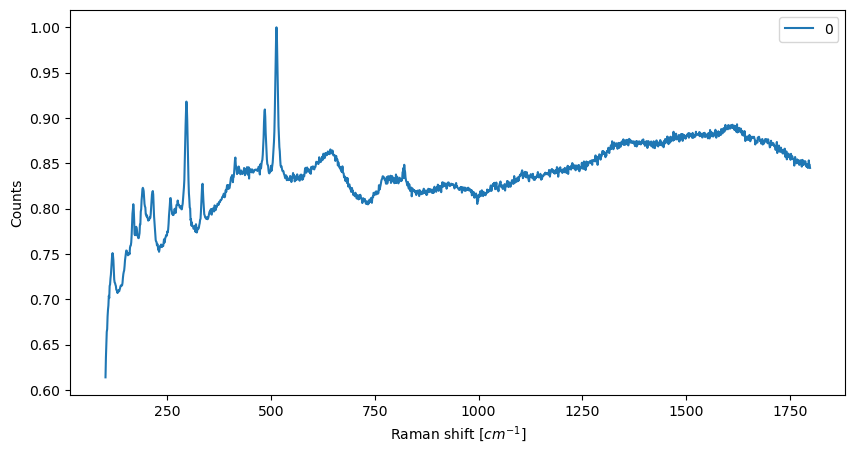

In [218]:
# take an unknown spectra with bkg

S=pr.type2spectra('txt10')
S = S[:,S[0]<1800]
pr.plot(S)

## Prepare resized library

In [219]:
# create matrix LIB

LIB = np.zeros((len(lib_names), len(S[0])))

for i in range(len(lib_names)):
    P = np.copy(lib[lib_names[i]])

    # restringo P se troppo grande
    if P[0][0]<S[0][0] or P[0][-1]>S[0][-1]:
        P = P[:,P[0]>=S[0][0]]
        P = P[:,P[0]<=S[0][-1]]



    # generate PAD with zeros of P
    n_min = np.where(S[0]==P[0][0])
    n_max = np.where(S[0]==P[0][-1])
    
    P_pad = np.copy(S)
    P_pad[1][n_min[0][0]:n_max[0][0]+1] = P[1]
    P_pad[1][0:n_min[0][0]] *= 0 
    P_pad[1][n_max[0][0]:] *= 0

    LIB[i] = P_pad[1]/(np.linalg.norm(P))

## Matrice di bkg template functions

In [220]:
# generate array of bkg template functions

##########
sigma = 40
p = 200
delta = 0 #(>> sigma)
method = 'sinc'
##########

# gaussian function in numpy
def gauss(x, mu, sigma):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))

# sinc function in numpy
def sinc(x, mu, sigma):
    return np.sinc((x-mu)/sigma)

mus = np.linspace(S[0,0]-delta, S[0,-1]+delta, p)

G = np.zeros((p,len(S[0])))

if method == 'gauss':
    for i in range(p):
        G[i] = gauss(S[0], mus[i], sigma)

if method == 'sinc':
    for i in range(p):
        G[i] = sinc(S[0], mus[i], sigma)

,name,ID,match,res,I,bkg,fit
0,Albite,2,0.962011,1.682083e+06,"[811.9044025778127, 484564191456373.7, -351799...","[4567.743408203125, 4561.54150390625, 4589.791...","[4567.743408203125, 4561.54150390625, 4589.791..."
1,Orthoclase,59,0.662533,6.708223e+06,"[-4747.218076220655, 3063393856574089.5, -3330...","[4332.557861328125, 4453.276611328125, 4579.93...","[4332.557861328125, 4453.276611328125, 4579.93..."
2,Chalcopyrite,27,0.697904,7.016364e+06,"[502.83224104253964, -4468779106478354.0, -233...","[4495.965087890625, 4528.2076416015625, 4582.7...","[4495.965087890625, 4528.2076416015625, 4582.7..."
3,Microcline,22,0.691048,7.199614e+06,"[-1899.7769882620667, 8802465847883678.0, 1.43...","[4536.1630859375, 4539.83984375, 4599.88183593...","[4536.1630859375, 4539.83984375, 4599.88183593..."
4,Nontronite,36,0.566525,8.193250e+06,"[566.1812767845864, 4593201947125038.0, 864940...","[4474.98876953125, 4562.369873046875, 4660.111...","[4474.98876953125, 4562.369873046875, 4660.111..."
5,Zoisite,19,0.492913,8.453177e+06,"[1969.533181522693, 2350181736925341.5, -1.580...","[4555.484375, 4544.9013671875, 4570.9272460937...","[4555.484375, 4544.9013671875, 4570.9272460937..."
6,Lepidocrocite,49,0.597051,9.245122e+06,"[193402.18089451492, -3890421612216007.5, 7959...","[4606.10107421875, 4562.766845703125, 4583.677...","[4606.10107421875, 4562.766845703125, 4583.677..."
7,Goethite,56,0.552652,9.288933e+06,"[10567.723676454129, 7280177145003622.0, 76806...","[4458.03515625, 4500.17626953125, 4562.2861328...","[4458.03515625, 4500.17626953125, 4562.2861328..."
8,Pyrolusite,48,0.514101,9.357384e+06,"[181380.9157552061, -8215793096688218.0, -2310...","[4470.757568359375, 4534.1318359375, 4611.9455...","[4470.757568359375, 4534.1318359375, 4611.9455..."
9,Dwornikite,34,0.652681,9.389778e+06,"[13635.731119646995, 6249702423882082.0, -1.20...","[4674.95263671875, 4601.439453125, 4612.71875,...","[4674.95263671875, 4601.439453125, 4612.71875,..."


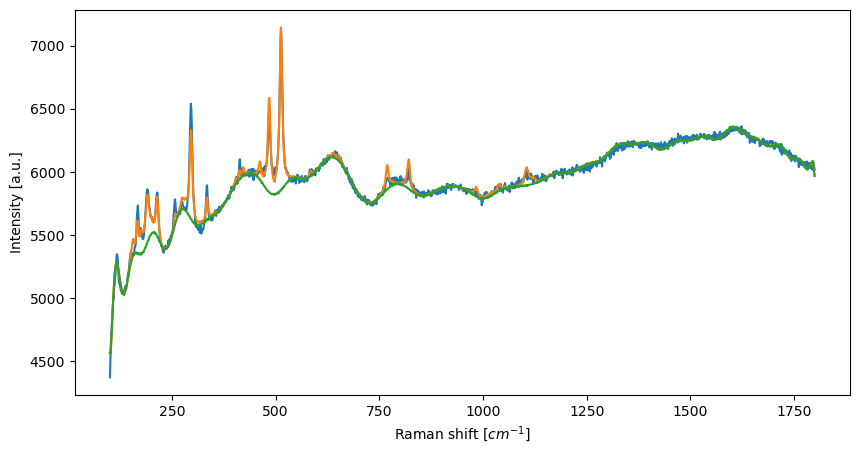

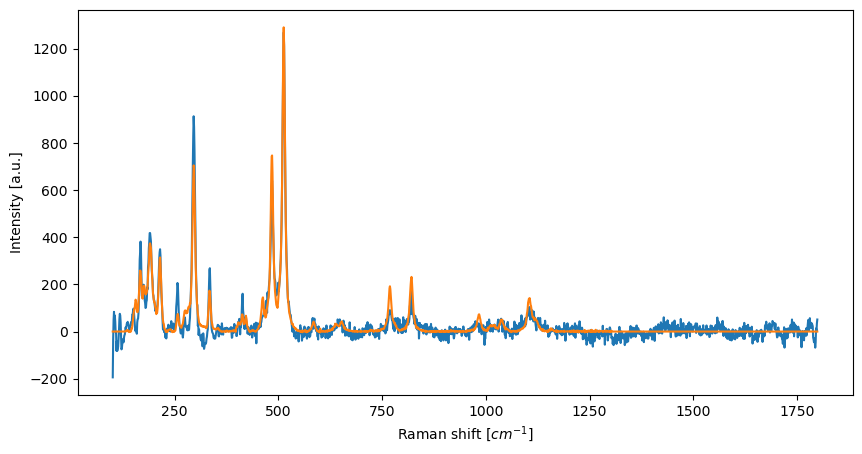

In [221]:
# FIT with shifts
# cosine similarity between two vectors
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


##########
shift = 5
##########
shift_vec = np.arange(-shift,shift+1)


output = []

Ps = np.zeros((2*shift+1, len(S[0])))

for i in range(len(lib_names)):

    for s in range(len(shift_vec)):

        P_shifted = np.roll(LIB[i],shift_vec[s])

        if s>0:
            P_shifted[:shift_vec[s]] *= 0
        if s<0:
            P_shifted[shift_vec[s]:] *= 0

        Ps[s] = P_shifted

    #### fit
    Y = np.append(Ps, G, axis=0)    # si puo eliminare il transpose ....
    out = scipy.linalg.lstsq(Y.transpose(), S[1])
    
    # salvo risultato
    fit = (Y.transpose()*out[0]).sum(axis=1)
    I = out[0][:2*shift+1]
    bkg = (Y[2*shift+1:].transpose()*out[0][2*shift+1:]).sum(axis=1)
    
    # riassumo info
    res = ((fit-S[1])**2).sum()
    LIB[i]= np.sum(I * Ps.transpose(), axis=1)
    match = cosine_similarity(S[1]-bkg, LIB[i])

    # SALVO
    output.append([lib_names[i], i, match, res, I, bkg, fit])
    
output = pd.DataFrame(output, columns=['name', 'ID', 'match', 'res', 'I', 'bkg', 'fit']).sort_values(by='res', ascending=True).reset_index(drop=True)
display(output.head(10))



plt.figure(figsize=(10,5))
plt.xlabel(r'Raman shift [$cm^{-1}$]')
plt.ylabel('Intensity [a.u.]')

plt.plot(S[0], S[1])
plt.plot(S[0], output['fit'][0])
plt.plot(S[0], output['bkg'][0])

plt.figure(figsize=(10,5))
plt.xlabel(r'Raman shift [$cm^{-1}$]')
plt.ylabel('Intensity [a.u.]')
plt.plot(S[0], S[1]-output['bkg'][0])
plt.plot(S[0], LIB[output['ID'][0]])

,name,ID,match,res,shift,I,bkg,fit
0,Albite,2,0.968776,1.383335e+06,0,1.003666,"[4421.49534034729, 4501.040508270264, 4586.233...","[4421.49534034729, 4501.040508270264, 4586.233..."
1,Orthoclase,59,0.671330,6.116269e+06,0,0.985127,"[4372.99657201767, 4492.573499679565, 4601.677...","[4372.99657201767, 4492.573499679565, 4601.677..."
2,Chalcopyrite,27,0.686817,6.990855e+06,0,0.984608,"[4412.6357707977295, 4498.350836753845, 4587.4...","[4412.6357707977295, 4498.350836753845, 4587.4..."
3,Microcline,22,0.684503,7.050596e+06,0,0.937326,"[4357.778600215912, 4490.549054145813, 4607.42...","[4357.778600215912, 4490.549054145813, 4607.42..."
4,Nontronite,36,0.522838,8.099655e+06,1,0.882287,"[4454.497453689575, 4517.9448890686035, 4589.3...","[4454.497453689575, 4517.9448890686035, 4589.3..."
5,Zoisite,19,0.489888,8.121858e+06,0,0.972052,"[4386.408910751343, 4492.716590881348, 4594.59...","[4386.408910751343, 4492.716590881348, 4594.59..."
6,Dwornikite,34,0.591446,8.391038e+06,-1,0.797677,"[4407.901905059814, 4502.393721580505, 4595.12...","[4407.901905059814, 4502.393721580505, 4595.12..."
7,Lepidocrocite,49,0.640534,8.722373e+06,-4,1.079525,"[4439.736775875092, 4508.854167938232, 4586.03...","[4439.736775875092, 4508.854167938232, 4586.03..."
8,Pyrolusite,48,0.506855,9.078636e+06,-1,0.998761,"[4426.29208946228, 4502.505977630615, 4585.328...","[4426.29208946228, 4502.505977630615, 4585.328..."
9,Goethite,56,0.590769,9.122380e+06,0,1.108530,"[4403.384722232819, 4499.326832771301, 4593.67...","[4403.384722232819, 4499.326832771301, 4593.67..."


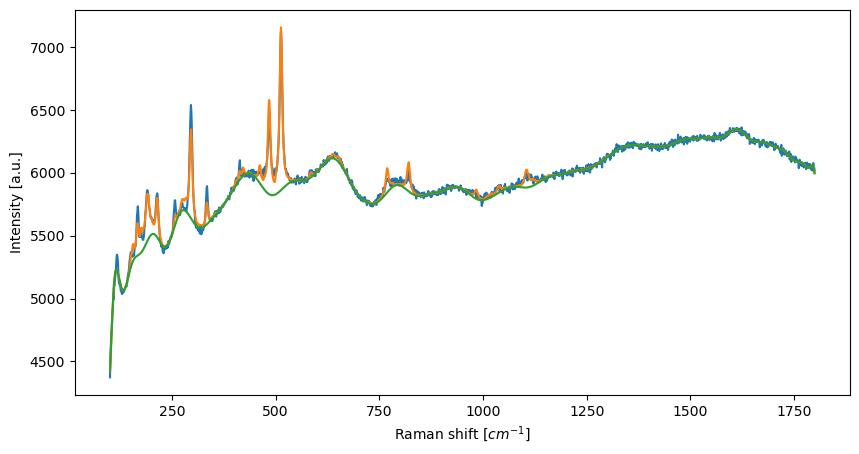

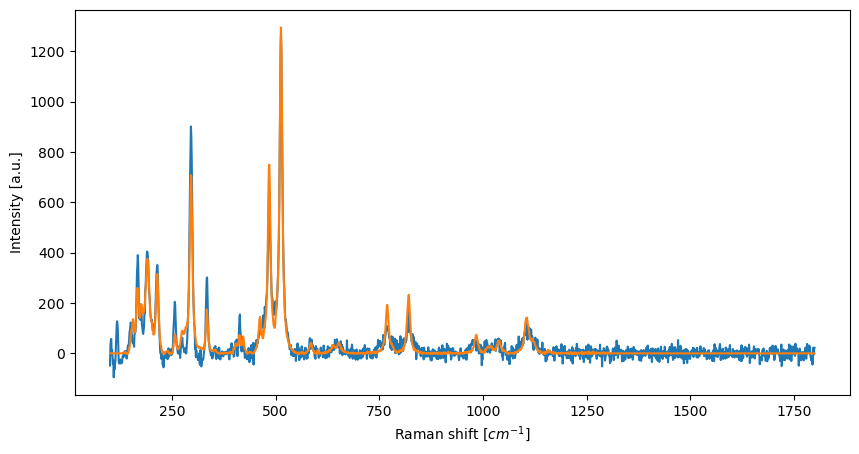

In [222]:

# FIT with shifts
# cosine similarity between two vectors
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

##########
shift = 5
##########
shift_vec = np.arange(-shift,shift+1)


output = []

for i in range(len(lib_names)):

    best_res = 0
    best_shift = 0

    for s in shift_vec:

        P_shifted = np.roll(LIB[i],s)

        if s>0:
            P_shifted[:s] *= 0
        if s<0:
            P_shifted[s:] *= 0

        # fit
        Y = np.append([P_shifted], G, axis=0)    # si puo eliminare il transpose ....

        out = scipy.linalg.lstsq(Y.transpose(), S[1])
        
        fit = (Y.transpose()*out[0]).sum(axis=1)
        I = out[0][0]
        bkg = (Y[1:].transpose()*out[0][1:]).sum(axis=1)
        
        res = ((fit-S[1])**2).sum()

        if res<best_res or best_res==0:
            best_res = res
            best_shift = s
            best_fit = fit
            best_bkg = bkg
            best_P_shifted = P_shifted
            best_I = I

    res = best_res
    shift = best_shift
    fit = best_fit
    bkg = best_bkg
    LIB[i]= best_P_shifted
    I = best_I

    match = cosine_similarity(S[1]-bkg, LIB[i])

    output.append([lib_names[i], i, match, res, shift, I, bkg, fit])
    
output = pd.DataFrame(output, columns=['name', 'ID', 'match', 'res', 'shift', 'I', 'bkg', 'fit']).sort_values(by='res', ascending=True).reset_index(drop=True)
display(output.head(10))

plt.figure(figsize=(10,5))
plt.xlabel(r'Raman shift [$cm^{-1}$]')
plt.ylabel('Intensity [a.u.]')

plt.plot(S[0], S[1])
plt.plot(S[0], output['fit'][0])
plt.plot(S[0], output['bkg'][0])

plt.figure(figsize=(10,5))
plt.xlabel(r'Raman shift [$cm^{-1}$]')
plt.ylabel('Intensity [a.u.]')
plt.plot(S[0], S[1]-output['bkg'][0])
plt.plot(S[0], LIB[output['ID'][0]]*output['I'][0])
